#Problem Statement

Steam is a video game digital distribution service with a vast community of gamers globally. A lot of gamers write reviews on the game page and have the option of choosing whether they would recommend this game to others or not. However, determining this sentiment automatically from the text can help Steam to automatically tag such reviews extracted from other forums across the internet and can help them better judge the popularity of games.

Given the review text with user recommendation, the task is to predict whether the reviewer recommended the game titles available in the test set on the basis of review text and other information.

In simpler terms, the task at hand is to identify whether a given user review is good or bad.

Competition link - https://datahack.analyticsvidhya.com/contest/janatahack-nlp-hackathon/

Optimization will be based on F1-score

In this Notebook I'll apply some simple text preprocessing and try to select an ML model, use Tfidf feature extractor and optimize F1-score

## Install pycaret

In [1]:
!pip install pycaret

     |████████████████████████████████| 264 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 167 kB 37.3 MB/s 
     |████████████████████████████████| 108 kB 53.6 MB/s 
     |████████████████████████████████| 1.7 MB 42.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 248 kB 59.2 MB/s 
     |████████████████████████████████| 2.0 MB 18.9 MB/s 
     |████████████████████████████████| 1.3 MB 44.7 MB/s 
     |████████████████████████████████| 6.8 MB 18.7 MB/s 
     |████████████████████████████████| 271 kB 79.6 MB/s 
     |████████████████████████████████| 14.4 MB 60 kB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 675 kB 47.3 MB/s 
     |████████████████████████████████| 10.1 MB 29.2 MB/s 
     |██████████████████

## Install necessary modules

In [2]:
from pycaret.nlp import *
from pycaret.classification import *

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Import training data

In [52]:
df = pd.read_csv('train.csv')
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [53]:
df['title'][0]

"Spooky's Jump Scare Mansion"

In [54]:
df['user_review'][2000]

'Thank you for the past 4 years. I really had fun playing DotA 2 but today is the day i will never ever play another game. The amount of russian players, that neither communicate nor pick like they are playing a TEAM-game is too ♥♥♥♥ing high. If they communicate they only do it in their own ♥♥♥♥ing language. Which mostly contains♥♥♥♥♥♥ blyad, idnahui or other piece of their♥♥♥♥♥♥language. It seem slike the avery intelligence of a DotA player has become less then a piece of the♥♥♥♥♥♥i produce in my every single day of my life. The level of fun you have these days is about the same as getting kicked in the balls and then get them chopped off. Thank you for ruining this community by not creating region locks and letting these imbacils controll our servers.♥♥♥♥ you Valve♥♥♥♥ you Mother Russia~A non Russian player'

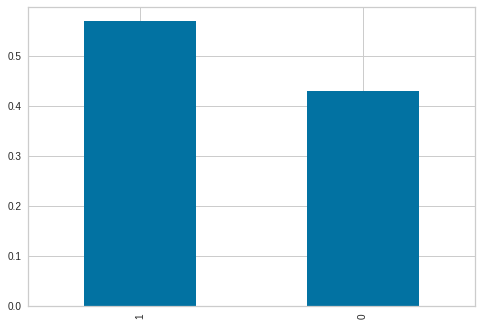

In [55]:
df['user_suggestion'].value_counts(normalize = True).plot(kind = 'bar') # proportions of negative and positive user reviews/recommendation

## Text Preprocessing

In [56]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk import pos_tag, word_tokenize
from collections import defaultdict
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Fucntions for text preprocessing

In [57]:
# Lemmatizer function
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
lmtzr = WordNetLemmatizer()

def lemmatize(sentence):
  lemmatized_sentence = []
  tokens = word_tokenize(sentence)
  for token, tag in pos_tag(tokens):  # returns token and corresponding tag from list of tokens
    lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #print(token, "=>", lemma)
    lemmatized_sentence.append(lemma)
  return ' '.join(lemmatized_sentence)

def clean_text(text):
  cleaned = re.sub("\d+"," ",text.lower()).split() # remove numbers
  cleaned = " ".join(cleaned)
  cleaned = [word for word in cleaned.split() if word not in stopwords] #remove stopwords
  cleaned = " ".join(cleaned)
  cleaned = re.sub("[^a-zA-Z]"," ",cleaned).split() # 
  cleaned = " ".join(cleaned)
  cleaned = lemmatize(cleaned)
  return cleaned


### Preprocessing Training Data

In [58]:
df['cleaned_user_review'] = df['user_review'].apply(clean_text)
df.head()

,review_id,title,year,user_review,user_suggestion,cleaned_user_review
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,i m scar hear creepy voice i ll pause moment w...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,best game well sam pepper s youtube account ne...
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,littly iffy control know play easy master i ve...
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,great game fun colorful that a side note thoug...
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,many game cute tag right next horror tag steam...


In [59]:
df['cleaned_user_review'][2000] 

'thank past year really fun play dota today day never ever play another game amount russian player neither communicate pick like play team game ing high communicate ing language mostly contain blyad idnahui piece their language seem slike avery intelligence dota player become less piece the i produce every single day life level fun day get kick ball get chop off thank ruin community create region lock let imbacils controll server valve mother russia a non russian player'

### Applying TfidfVectorizer on the cleaned training data

In [60]:
no_features = 8000
tf_vectorizer = TfidfVectorizer(min_df= 0.015, max_df=0.8, max_features= no_features, ngram_range=[1,3]) #CountVectorizer(min_df=.015, max_df=.8, max_features=no_features, ngram_range=[1, 3], analyzer = 'word') #analyzer{‘word’, ‘char’, ‘char_wb’} 

In [61]:
%time features = tf_vectorizer.fit_transform(df['cleaned_user_review'])

CPU times: user 11.9 s, sys: 257 ms, total: 12.1 s
Wall time: 12.1 s


In [62]:
features_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())
features_df.tail(3)

,ability,able,absolutely,access,access reviewi,access reviewthe,access reviewthis,access reviewthis game,account,across,action,actual,actually,add,addict,addictive,advantage,again,ago,ai,aim,air,aircraft,all,allow,almost,alone,along,alot,alpha,already,also,although,always,amaze,amazing,amount,and,animal,annoy,...,walk,wall,want,want play,war,waste,waste time,watch,way,weapon,week,well,what,whatever,which,while,whole,why,willing,win,win game,wish,with,within,without,wont,word,work,world,worth,would,would recommend,write,wrong,yeah,year,year ago,yes,yet,you
17491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.089463,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.054066,0.098933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139350,0.106361,0.0,0.0,0.0
17492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
17493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195162,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351379,0.000000,0.0,0.0,0.0


In [63]:
new_df = pd.concat([features_df,df['user_suggestion']],axis=1)
new_df.tail(3)

,ability,able,absolutely,access,access reviewi,access reviewthe,access reviewthis,access reviewthis game,account,across,action,actual,actually,add,addict,addictive,advantage,again,ago,ai,aim,air,aircraft,all,allow,almost,alone,along,alot,alpha,already,also,although,always,amaze,amazing,amount,and,animal,annoy,...,wall,want,want play,war,waste,waste time,watch,way,weapon,week,well,what,whatever,which,while,whole,why,willing,win,win game,wish,with,within,without,wont,word,work,world,worth,would,would recommend,write,wrong,yeah,year,year ago,yes,yet,you,user_suggestion
17491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.089463,0.0,0.0,0.0,0.0,0.0,...,0.0,0.054066,0.098933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139350,0.106361,0.0,0.0,0.0,1
17492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1
17493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195162,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351379,0.000000,0.0,0.0,0.0,1


## Set up PyCaret Pipeline

In [64]:
#Shuffle training dataset 
train_df = new_df.sample(frac=1, random_state = 42)
train_df.shape

(17494, 836)

In [65]:
numeric_features = list(features_df.columns)
%time temp = setup(data = train_df, target = 'user_suggestion',numeric_features = numeric_features, use_gpu=True, fold = 5)

,Description,Value
0,session_id,2209
1,Target,user_suggestion
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(17494, 836)"
5,Missing Values,False
6,Numeric Features,835
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 34.4 s, sys: 875 ms, total: 35.2 s
Wall time: 39.7 s


In [66]:
len(numeric_features)

835

In [67]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8199,0.9001,0.8652,0.8260,0.8451,0.6303,0.6315,0.560
svm,SVM - Linear Kernel,0.8189,0.0000,0.8593,0.8285,0.8435,0.6287,0.6297,0.752
ridge,Ridge Classifier,0.8180,0.0000,0.8591,0.8271,0.8427,0.6268,0.6276,0.332
lda,Linear Discriminant Analysis,0.8150,0.8924,0.8533,0.8266,0.8397,0.6212,0.6218,3.396
lightgbm,Light Gradient Boosting Machine,0.8107,0.8907,0.8560,0.8190,0.8370,0.6115,0.6127,5.586
et,Extra Trees Classifier,0.8047,0.8810,0.8572,0.8100,0.8329,0.5983,0.5998,9.990
rf,Random Forest Classifier,0.7939,0.8715,0.8503,0.7995,0.8241,0.5758,0.5775,8.384
qda,Quadratic Discriminant Analysis,0.7815,0.8274,0.8202,0.8003,0.8100,0.5531,0.5535,3.290
nb,Naive Bayes,0.7774,0.8336,0.7722,0.8248,0.7976,0.5509,0.5525,0.200
gbc,Gradient Boosting Classifier,0.7637,0.8497,0.8822,0.7473,0.8092,0.5046,0.5168,23.276


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2209, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
%time lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8232,0.9044,0.8561,0.8363,0.8461,0.6385,0.6387
1,0.8179,0.9008,0.8640,0.8237,0.8434,0.6261,0.6272
2,0.8183,0.8946,0.8807,0.8145,0.8463,0.6249,0.6278
3,0.8122,0.8961,0.8462,0.8271,0.8365,0.6159,0.6161
4,0.8281,0.9047,0.8792,0.8286,0.8532,0.6463,0.6480
Mean,0.8199,0.9001,0.8652,0.8260,0.8451,0.6303,0.6315
SD,0.0054,0.0041,0.0133,0.0071,0.0054,0.0107,0.0109


CPU times: user 5.75 s, sys: 1.3 s, total: 7.06 s
Wall time: 3.88 s


In [71]:
%time tuned_lr = tune_model(lr, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8224,0.9041,0.8590,0.8332,0.8459,0.6364,0.6368
1,0.8187,0.9001,0.8691,0.8218,0.8448,0.6273,0.6287
2,0.8191,0.8938,0.8828,0.8143,0.8472,0.6265,0.6295
3,0.8146,0.8963,0.8541,0.8256,0.8396,0.6202,0.6207
4,0.8281,0.9052,0.8792,0.8286,0.8532,0.6463,0.6480
Mean,0.8206,0.8999,0.8688,0.8247,0.8461,0.6313,0.6327
SD,0.0045,0.0044,0.0111,0.0064,0.0044,0.0091,0.0092


CPU times: user 6.86 s, sys: 1.36 s, total: 8.21 s
Wall time: 42.3 s


In [72]:
# finalize the model
lr_final = finalize_model(tuned_lr)

## Preformance plots

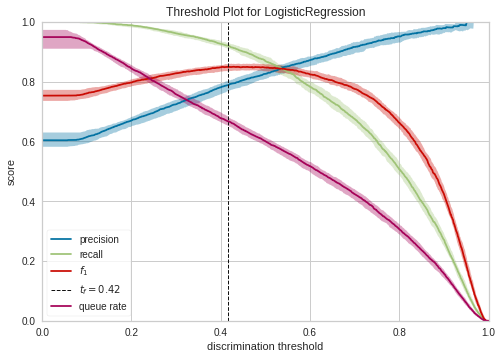

In [73]:
plot_model(lr_final, plot = 'threshold')

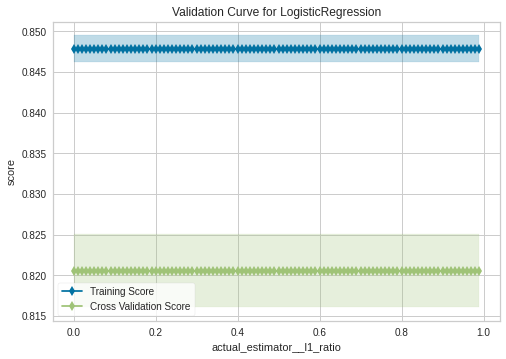

In [74]:
plot_model(lr_final, plot = 'vc')

From above it's evident that the model is overfitting. I'll further try to proprocess the data to create more important features in later notebooks

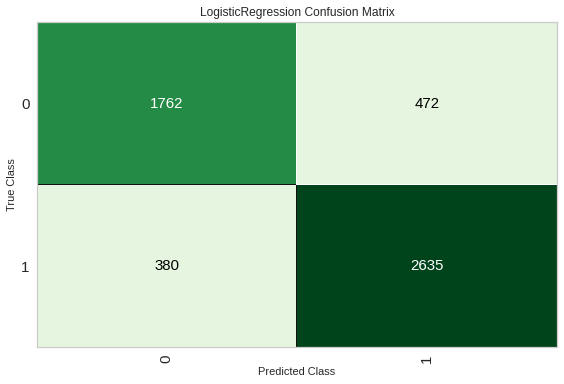

In [75]:
plot_model(lr_final, plot = 'confusion_matrix')

## Generating pedcitions from the test data

In [76]:
test_df = pd.read_csv('test.csv')
test_df.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [77]:
test_df['cleaned_user_review'] = test_df['user_review'].apply(clean_text)
test_features = tf_vectorizer.transform(test_df['cleaned_user_review'])

In [78]:
test_features_df = pd.DataFrame(test_features.toarray(), columns=tf_vectorizer.get_feature_names())
test_features_df.tail(3)

,ability,able,absolutely,access,access reviewi,access reviewthe,access reviewthis,access reviewthis game,account,across,action,actual,actually,add,addict,addictive,advantage,again,ago,ai,aim,air,aircraft,all,allow,almost,alone,along,alot,alpha,already,also,although,always,amaze,amazing,amount,and,animal,annoy,...,walk,wall,want,want play,war,waste,waste time,watch,way,weapon,week,well,what,whatever,which,while,whole,why,willing,win,win game,wish,with,within,without,wont,word,work,world,worth,would,would recommend,write,wrong,yeah,year,year ago,yes,yet,you
8042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8043,0.123344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8044,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
unseen_predictions = predict_model(lr_final, data=test_features_df)
unseen_predictions.head()

,ability,able,absolutely,access,access reviewi,access reviewthe,access reviewthis,access reviewthis game,account,across,action,actual,actually,add,addict,addictive,advantage,again,ago,ai,aim,air,aircraft,all,allow,almost,alone,along,alot,alpha,already,also,although,always,amaze,amazing,amount,and,animal,annoy,...,want,want play,war,waste,waste time,watch,way,weapon,week,well,what,whatever,which,while,whole,why,willing,win,win game,wish,with,within,without,wont,word,work,world,worth,would,would recommend,write,wrong,yeah,year,year ago,yes,yet,you,Label,Score
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.129895,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.092609,0.0,0.0,0.0,0.0,0.000000,0.000000,0.238566,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1,0.5833
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.131452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.114499,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.137374,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076635,0.139776,0.0,0.000000,0.000000,0.297643,0.0,0.000000,0.0,0.000000,0,0.9821
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046069,0.000000,0.0,0.060336,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.100004,0.0,0.000000,0.0,0.0,0.046694,0.0,0.0,0.0,...,0.092193,0.0,0.0,0.0,0.0,0.108268,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.054835,0.000000,0.0,0.0,0.0,0.0,0.037672,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.039603,0.0,0.145402,0.0,0.000000,0,0.8618
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.191665,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0,0.8978
4,0.0,0.0,0.042465,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074392,0.042498,0.0,0.048715,0.0,0.0,0.034802,0.040704,0.000000,0.048188,0.0,0.0,0.047322,0.0,0.107657,0.0,0.035519,0.0,0.0,0.037700,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.054996,0.095876,0.0,0.095389,0.043263,0.0,0.0,0.0,0.041605,0.0,0.049106,0.028805,0.0,0.000000,0.084632,0.0,0.0,0.0,0.0,0.060832,0.0,0.0,0.074095,0.045048,0.0,0.042787,0.093677,0.000000,0.0,0.000000,0.0,0.088639,1,0.9083


In [80]:
predictions = pd.concat((pd.Series(test_df['review_id']),unseen_predictions), axis =1)
predictions.head()

,review_id,ability,able,absolutely,access,access reviewi,access reviewthe,access reviewthis,access reviewthis game,account,across,action,actual,actually,add,addict,addictive,advantage,again,ago,ai,aim,air,aircraft,all,allow,almost,alone,along,alot,alpha,already,also,although,always,amaze,amazing,amount,and,animal,...,want,want play,war,waste,waste time,watch,way,weapon,week,well,what,whatever,which,while,whole,why,willing,win,win game,wish,with,within,without,wont,word,work,world,worth,would,would recommend,write,wrong,yeah,year,year ago,yes,yet,you,Label,Score
0,1603,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.129895,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.092609,0.0,0.0,0.0,0.0,0.000000,0.000000,0.238566,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1,0.5833
1,1604,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.131452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.114499,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.137374,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076635,0.139776,0.0,0.000000,0.000000,0.297643,0.0,0.000000,0.0,0.000000,0,0.9821
2,1605,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046069,0.000000,0.0,0.060336,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.100004,0.0,0.000000,0.0,0.0,0.046694,0.0,0.0,...,0.092193,0.0,0.0,0.0,0.0,0.108268,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.054835,0.000000,0.0,0.0,0.0,0.0,0.037672,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.039603,0.0,0.145402,0.0,0.000000,0,0.8618
3,1606,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.191665,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0,0.8978
4,1607,0.0,0.0,0.042465,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074392,0.042498,0.0,0.048715,0.0,0.0,0.034802,0.040704,0.000000,0.048188,0.0,0.0,0.047322,0.0,0.107657,0.0,0.035519,0.0,0.0,0.037700,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.054996,0.095876,0.0,0.095389,0.043263,0.0,0.0,0.0,0.041605,0.0,0.049106,0.028805,0.0,0.000000,0.084632,0.0,0.0,0.0,0.0,0.060832,0.0,0.0,0.074095,0.045048,0.0,0.042787,0.093677,0.000000,0.0,0.000000,0.0,0.088639,1,0.9083


In [81]:
predictions.rename(columns= {'Label' : 'user_suggestion'}, inplace = True)
predictions.columns[-3:]

Index(['you', 'user_suggestion', 'Score'], dtype='object')

In [82]:
predictions[['review_id','user_suggestion']].to_csv('predictions.csv', index = False) # exporting predictiions to submission format